In [1]:
import math
import numpy as np
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
#from scipy.optimize import minimize
#import tensorflow as tf

PointConfiguration.set_engine('internal')
#PointConfiguration.set_engine('topcom')
print 'Done.'

Done.


In [2]:
def exist(pts, latt):
    latt = np.array(latt)
    for i in range(pts.shape[0]):
        if pts[i][0]==latt[0]:
            if pts[i][1]==latt[1]:
                if pts[i][2]==latt[2]:
                    return 1
    return 0

def contain(poly, latt):
    if poly.contains(latt) == 1:
        return 1
    else:
        poly_latt = Polyhedron(vertices = [tuple(latt)])
        vert = next(poly_latt.vertex_generator())
        face_eq = poly.Hrepresentation()
        for eq in face_eq:
            if eq.contains(vert) != 1:
                return 0
        return 1
    return 0

def check_latt(p):
    pts = np.array(p)
    pts_max = int(max(np.amax(pts, axis=0)))+1
    pts_min = int(min(np.amin(pts, axis=0)))-1
    poly = Polyhedron(p)
    pts_new = pts
    for i in range(pts_min, pts_max):
        for j in range(pts_min, pts_max):
            for k in range(pts_min, pts_max):
                latt = [i,j,k]
                if exist(pts, latt) == 1:
                    continue
                if contain(poly, latt) == 1:
                    pts_new = np.append(pts_new, np.array(latt).reshape((1,3)), axis = 0)  
    pts_new = pts_new.tolist()
    return pts_new


def four_cross(v1, v2, v3, v4):
    #Compute cross product of three 4-vectors
    #print "input vectors: ", v1, v2, v3, v4
    v = np.zeros((4,))
    counter = 0
    
    for i in range(4):
        mat = [v1[np.arange(len(v1))!=i].tolist(), v2[np.arange(len(v2))!=i].tolist(), v3[np.arange(len(v3))!=i].tolist()]
        mat = matrix(ZZ, mat)
        #print 'matrix: '
        #print mat
        if counter == 1:
            v[i] = -1*mat.det()
            counter = 0
            #print 'neg: ', v[i]
            continue
        elif counter == 0:
            v[i] = mat.det()
            counter = 1
            #print 'pos: ', v[i]
    #print v
    mat = matrix(RR, [v1.tolist(), v2.tolist(), v3.tolist(), v4.tolist()])
    
    if mat.det() < 0:
        #print 'original: ', v
        v = -1*v
        #print 'changed: ', v
    #print 'vector: ', v
    return v

def Hilb(triang_list):
    triang = []
    # Add 1 at the end of all verticies
    for tetra in triang_list:
        tetra_new = []
        for vert in tetra:
            vert_new = np.append(np.array(vert),1).tolist()
            tetra_new.append(vert_new)
        triang.append(tetra_new)
    triang = np.array(triang)
    #print 'input: ', triang_list
    #print 'triang: ', triang
    power = np.zeros(shape = triang.shape)
    Hilb = 0
    t = var('t')
    t1 = var('t1')
    t2 = var('t2')
    t3 = var('t3')
    t4 = var('t4')
    for tri in range(triang.shape[0]):
        hilb = 1
        t_prod = 1
        for i in range(4):
            #Multiplying by -1 is optional
            power[tri][i] = -1*four_cross(triang[tri][i], triang[tri][np.remainder(i+1, 4)], triang[tri][np.remainder(i+2, 4)], triang[tri][np.remainder(i+3, 4)])
            t_prod = t1^(int(power[tri][i][0]))*t2^(int(power[tri][i][1]))*t3^(int(power[tri][i][2]))*t4^int((power[tri][i][3]))
            hilb *= (1-t_prod)^(-1)
        #print 'Hilbert: ', hilb
        Hilb += hilb
    
    
    m = var('m')
    b1 = var('b1')
    b2 = var('b2')
    b3 = var('b3')
    b4 = var('b4')
    Hilb *= m^4
    
    #print 'Hilb: ', str(Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp())).replace('e', 'E')
    
    
    Series = Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp()).series(m==0, 1)
    Series = Series.truncate()
    
    return Series

print 'Done.'

Done.


In [3]:
from scipy.optimize import fsolve

def func(p, *d):
    f1, f2, f3 = d
    return (f1(b1 = p[0], b2 = p[1], b3 = p[2]), f2(b1 = p[0], b2 = p[1], b3 = p[2]), f3(b1 = p[0], b2 = p[1], b3 = p[2]))

def constraint(Series, sol):
    vol = Series(b1 = sol[0], b2 = sol[1], b3 = sol[2])
    if vol <= 1 and vol >= float(1/((3*SIDE_LENGTH)**3)):
        return 1, vol

    print 'volume: ', vol, ' is out of bounds.'

    return 0, -1

def NSolve(Series):
    d1 = diff(Series, b1)
    d2 = diff(Series, b2)
    d3 = diff(Series, b3)
    d = (d1, d2, d3)
    const = 0
    count = 0

    while const == 0:
        d1_0 = np.random.uniform(low=0, high=5)
        d2_0 = np.random.uniform(low=0, high=5)
        d3_0 = np.random.uniform(low=0, high=5)
        print 'reset starting point: ', d1_0, d2_0, d3_0

        try:
            sol = fsolve(func, x0 = np.array([d1_0, d2_0, d3_0]), args = d)
            print 'solution: ', sol
        except:
            continue
        
        const, vol = constraint(Series, sol)

        count += 1
        if count > 1000:
            print 'Infinite loop. Force stop.'
            return -1, -1

    print 'Done.'

    return vol, sol

print 'Done.'

Done.


In [4]:
def exist(pts, latt):
    latt = np.array(latt)
    for i in range(pts.shape[0]):
        if pts[i][0]==latt[0]:
            if pts[i][1]==latt[1]:
                if pts[i][2]==latt[2]:
                    return 1
    return 0

def dist(p1, p2):
    return sqrt((p1[0]-p2[0])^2+(p1[1]-p2[1])^2+(p1[2]-p2[2])^2)

def on_edge(latt, poly):
    edges = poly.faces(1)
    num_edges = len(edges)
    for i in range(num_edges):
        pt1 = list(edges[i].vertices()[0])
        pt2 = list(edges[i].vertices()[1])
        if (dist(pt1, pt2) == (dist(pt1, latt) + dist(pt2, latt))):
            return 1
    return 0

def on_face(latt, poly):
    faces = poly.faces(2)
    for face in poly.faces(2):
        face_pts = [list(face.vertices()[i]) for i in range(len(face.vertices()))]
        face_poly = Polyhedron(face_pts)
        if face_poly.contains(latt) == 1:
            return 1
    return 0

def count_pts(pts):
    # Count the number of corner points, edge points, face points, and body points
    num_corner = len(pts)
    num_edge = 0
    num_face = 0
    num_body = 0
    #edge = []
    #face = []
    #body = []
    pts_max = int(max(np.amax(pts, axis=0)))+1
    pts_min = int(min(np.amin(pts, axis=0)))-1
    #print 'pts_max: ', pts_max
    #print 'pts_min: ', pts_min
    poly = Polyhedron(pts)
    pts_new = pts
    for i in range(pts_min, pts_max):
        for j in range(pts_min, pts_max):
            for k in range(pts_min, pts_max):
                latt = [i,j,k]
                if exist(np.array(pts), latt) == 1:
                    continue
                if on_edge(latt, poly) == 1:
                    num_edge += 1
                    #edge.append(latt)
                elif on_face(latt, poly) == 1:
                    num_face += 1
                    #face.append(latt)
                elif poly.interior_contains(latt) == 1:
                    num_body += 1
                    #body.append(latt)
    #print 'edge: ', edge
    #print 'face: ', face
    #print 'body: ', body
    return [num_corner, num_edge, num_face, num_body]

print 'Done.'

Done.


In [5]:
def idx_to_pts(triang, pts):
    # Input a list of lists of indicies
    # Output a list of lists of points
    triang_new = []
    for i in range(len(triang)):
        triang_new.append([pts[j] for j in triang[i]])
    return triang_new

def init_cube(size):
    if size == 0:
        corner = []
        triang = []
        hilb = 0
        return corner, triang, hilb
    # Initalize the cube
    cube_1 = [[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]]
    corner = (size*np.array(cube_1)).tolist()
    # Sample triangulation of a 1x1x1 cube:
    triang_cube_1_1 = [[[0,0,0],[1,0,0],[1,1,0],[0,0,1]]]
    triang_cube_1_2 = [[[0,0,1],[1,0,1],[1,0,0],[1,1,1]]]
    triang_cube_1_3 = [[[0,0,1],[1,1,1],[1,1,0],[1,0,0]]]
    triang_cube_1_4 = [[[0,0,0],[1,1,0],[0,1,0],[0,0,1]]]
    triang_cube_1_5 = [[[0,0,1],[0,1,1],[1,1,0],[1,1,1]]]
    triang_cube_1_6 = [[[0,0,1],[0,1,1],[0,1,0],[1,1,0]]]
    triang_cube_1 = triang_cube_1_1 + triang_cube_1_2 + triang_cube_1_3 + triang_cube_1_4 + triang_cube_1_5 + triang_cube_1_6
    # Stack the cubes together
    triang = triang_cube_1
    if size == 1:
        hilb = []
        for tetra in triang:
            series = Hilb([tetra])
            hilb.append(series)
        return corner, triang, hilb
    for x in range(0,size):
        for y in range(0,size):
            for z in range(0,size):
                if x==0 and y==0 and z ==0:
                    continue
                move = [x, y, z]
                move = np.array(move)
                for i in range(6):
                    # The i-th tetrahedron
                    tetra_moved = []
                    for j in range(4):
                        # The j-th vertex
                        vert_moved = (np.array(triang_cube_1[i][j])+move).tolist()
                        tetra_moved.append(vert_moved)
                    triang.append(tetra_moved)
    # Also initialize the Hilbert series for each tetrahedron
    hilb = []
    for tetra in triang:
        series = Hilb([tetra])
        hilb.append(series)
    #print 'Init cube'
    #print 'Hilbert series: ', hilb
    return corner, triang, hilb

def cut_corner(p, corner, triang, hilb, count_ret):
    corner = check_latt(corner)
    corner.remove(p)
    cube_new = Polyhedron(corner)
    vertices = cube_new.vertices()
    corner = [list(vertices[i]) for i in range(len(vertices))]
    #print 'corner: ', corner
    # Find all the tetrahedron points that contain p
    adj_pts = []
    triang_new = []
   
    for tetra in triang:
        if p in tetra:
            # Hilbert
            for vertex in tetra:
                if (vertex != p) and (vertex not in adj_pts):
                    adj_pts.append(vertex)
            
            # I do not trust indexing
            series = Hilb([tetra])
            hilb.remove(series)
            
            count = np.array(count_pts(tetra))
            count_ret = np.array(count_ret) - count
            
        else:
            triang_new.append(tetra)
    print 'count after removing tetrahedron: ', count_ret
    if len(hilb) != len(triang_new):
        print 'len(hilb): ', len(hilb)
        print 'len(triang_new): ', len(triang_new)
    triang = triang_new
    #print 'adjacent points: ', adj_pts
    if len(adj_pts) > 3:
        patch = Polyhedron(adj_pts)
        patch_triang = PointConfiguration(adj_pts).triangulate()
        patch_triang = idx_to_pts(patch_triang, adj_pts)
        #print 'patch: ', patch_triang
        for tetra in patch_triang:
            if tetra not in triang:
                triang.append(tetra)
                series = Hilb([tetra])
                hilb.append(series)
                count = np.array(count_pts(tetra))
                count_ret += count
                count_ret = count_ret.tolist()
            # Also find the Hilbert Series for each tetrahedron
            #print 'Patch hilbert: ', series
            
            if len(hilb) != len(triang_new):
                print 'len(hilb): ', len(hilb)
                print 'len(triang_new): ', len(triang_new)
                print 'tetra: ', tetra
    print 'count after appending patches: ', count_ret
    #print 'number of tetrahedron: ', len(triang)
    print ''
    return corner, triang, hilb, count_ret

def plot_poly(pts):
    P = Polyhedron(pts)
    P.plot().save("/home/carnd/CYML/img/triang_cube_%d.png" % 1)
    img1 = mpimg.imread("/home/carnd/CYML/img/triang_cube_%d.png" % 1)
    plt.figure(figsize=(15, 15))
    plt.imshow(img1)
    plt.show()

    
points = [[0, 3, 0], [3, 3, 0], [3, 3, 3], [3, 3, 2], [0, 0, 0], [0, 0, 1], [0, 0, 3], [3, 2, 0], [2, 3, 0], [2, 3, 3],[0, 2, 0]]
def Triang_cube(size, num_iteration):
    corner, triang, hilb = init_cube(size)
    # Cut a random corner of the cube
    series_sum = 0
    for series in hilb:
        series_sum += series
    hilb_ret = [series_sum]
    count_ret = [count_pts(corner)]
    print 'Init count_ret: ', count_ret
    pts_ret = [corner]
    for i in range(num_iteration):
        #idx = np.random.randint(len(corner))
        #p = corner[idx]
        p = points[i]
        count = count_ret[i]
        print 'i: ', i
        print 'p: ', p
        corner, triang, hilb, count = cut_corner(p, corner, triang, hilb, count)
        
        try:
            assert len(hilb) == len(triang)
        except:
            print('len(hilb)', len(hilb))
            print('hilb', hilb)
            print('triang', triang)
            raise ValueError('Length not equal.')
        
        pts_ret.append(corner)
        
        #count = count_pts(corner)
        count_ret.append(count)
        print 'count_ret after all: ', count_ret
        
        series_sum = 0
        for series in hilb:
            series_sum += series
        hilb_ret.append(series_sum)
        
        #plot_poly(corner)
        print ''
        if len(corner) <= 3:
            break
    
    try:
        assert len(pts_ret) == len(count_ret) == len(hilb_ret)
    except:
        print('len(hilb_ret)', len(hilb_ret))
        print('hilb_ret', hilb_ret)
        print('len(count_ret)', len(count_ret))
        print('count_ret', count_ret)
        print('len(pts_ret)', len(pts_ret))
        print('pts_ret', pts_ret)
        raise ValueError('Length not equal.')
        
    return hilb_ret, pts_ret, count_ret

def vol_cube(size, num_iteration, train_path, count_path, pts_path):
    hilb, pts, count = Triang_cube(size, num_iteration)
    for i in range(len(hilb)):
        vol, sol = NSolve(hilb[i])
        sol = np.around(sol, decimals=4).tolist()
        print 'vol: ', vol
        print 'sol: ', sol
        train_set = [pts[i], vol]
        print 'train: ', train_set
        count_set = [count[i], vol]
        print 'count: ', count_set
        pts_set = [pts[i], sol]
        print 'pts_set: ', pts_set
        
        #train_file = open(train_path, 'w')
        #count_file = open(count_path, 'w')
        #pts_file = open(pts_path, 'w')
        #train_file.write("%s\n" % train_set)
        #count_file.write("%s\n" % count_set)
        #pts_file.write("%s\n" % pts_set)
        #train_file.close()
        #count_file.close()
        #pts_file.close()
    
    print 'Done.'

hilb_ret, pts_ret, count_ret = Triang_cube(3, 30)
'''
size = 3
num_iteration = 10
SIDE_LENGTH = size
train_path = '/home/carnd/CYML/output/train/cube/cube_%dx%d_%d.txt' % (size, size, num_iteration)
count_path = '/home/carnd/CYML/output/train/cube/count_%dx%d_%d.txt' % (size, size, num_iteration)
pts_path = '/home/carnd/CYML/output/polygon/cube/pts_%dx%d_%d.txt' % (size, size, num_iteration)
vol_cube(size, num_iteration, train_path, count_path, pts_path)
'''

Init count_ret:  [[8, 24, 24, 8]]
i:  0
p:  [0, 3, 0]
count after removing tetrahedron:  [ 0 24 24  8]
count after appending patches:  [4, 24, 24, 8]

count_ret after all:  [[8, 24, 24, 8], [4, 24, 24, 8]]

i:  1
p:  [3, 3, 0]
count after removing tetrahedron:  [-16  24  24   8]
count after appending patches:  [0, 24, 24, 8]

count_ret after all:  [[8, 24, 24, 8], [4, 24, 24, 8], [0, 24, 24, 8]]

i:  2
p:  [3, 3, 3]


KeyboardInterrupt: 

In [11]:
tetra = [[2, 0, 1], [3, 0, 1], [3, 1, 1], [2, 0, 2]]
series = Hilb([tetra])
triang =  [[[0, 2, 1], [1, 2, 1], [1, 2, 0], [1, 3, 1]], [[1, 0, 1], [1, 1, 1], [2, 1, 0], [2, 1, 1]], [[1, 0, 1], [1, 1, 1], [1, 1, 0], [2, 1, 0]], [[1, 0, 1], [2, 0, 1], [2, 1, 1], [1, 0, 2]], [[1, 0, 2], [2, 0, 2], [2, 0, 1], [2, 1, 2]], [[1, 0, 2], [2, 1, 2], [2, 1, 1], [2, 0, 1]], [[1, 0, 1], [2, 1, 1], [1, 1, 1], [1, 0, 2]], [[1, 0, 2], [1, 1, 2], [2, 1, 1], [2, 1, 2]], [[1, 0, 2], [1, 1, 2], [1, 1, 1], [2, 1, 1]], [[1, 1, 0], [2, 1, 0], [2, 2, 0], [1, 1, 1]], [[1, 1, 1], [2, 1, 1], [2, 1, 0], [2, 2, 1]], [[1, 1, 1], [2, 2, 1], [2, 2, 0], [2, 1, 0]], [[1, 1, 0], [2, 2, 0], [1, 2, 0], [1, 1, 1]], [[1, 1, 1], [1, 2, 1], [2, 2, 0], [2, 2, 1]], [[1, 1, 1], [1, 2, 1], [1, 2, 0], [2, 2, 0]], [[1, 1, 1], [2, 1, 1], [2, 2, 1], [1, 1, 2]], [[1, 1, 2], [2, 1, 2], [2, 1, 1], [2, 2, 2]], [[1, 1, 2], [2, 2, 2], [2, 2, 1], [2, 1, 1]], [[1, 1, 1], [2, 2, 1], [1, 2, 1], [1, 1, 2]], [[1, 1, 2], [1, 2, 2], [2, 2, 1], [2, 2, 2]], [[1, 1, 2], [1, 2, 2], [1, 2, 1], [2, 2, 1]], [[1, 2, 1], [2, 2, 1], [2, 2, 0], [2, 3, 1]], [[1, 2, 1], [2, 2, 1], [2, 3, 1], [1, 2, 2]], [[1, 2, 2], [2, 2, 2], [2, 2, 1], [2, 3, 2]], [[1, 2, 2], [2, 3, 2], [2, 3, 1], [2, 2, 1]], [[1, 2, 1], [2, 3, 1], [1, 3, 1], [1, 2, 2]], [[1, 2, 2], [1, 3, 2], [2, 3, 1], [2, 3, 2]], [[1, 2, 2], [1, 3, 2], [1, 3, 1], [2, 3, 1]], [[2, 0, 1], [2, 1, 1], [3, 1, 0], [3, 1, 1]], [[2, 0, 1], [2, 1, 1], [2, 1, 0], [3, 1, 0]], [[2, 0, 1], [3, 0, 1], [3, 1, 1], [2, 0, 2]], [[2, 0, 2], [3, 0, 2], [3, 0, 1], [3, 1, 2]], [[2, 0, 2], [3, 1, 2], [3, 1, 1], [3, 0, 1]], [[2, 0, 1], [3, 1, 1], [2, 1, 1], [2, 0, 2]], [[2, 0, 2], [2, 1, 2], [3, 1, 1], [3, 1, 2]], [[2, 0, 2], [2, 1, 2], [2, 1, 1], [3, 1, 1]], [[2, 0, 2], [3, 0, 2], [3, 1, 2], [2, 0, 3]], [[2, 0, 2], [3, 1, 2], [2, 1, 2], [2, 0, 3]], [[2, 0, 3], [2, 1, 3], [2, 1, 2], [3, 1, 2]], [[2, 1, 0], [3, 1, 0], [3, 2, 0], [2, 1, 1]], [[2, 1, 1], [3, 1, 1], [3, 1, 0], [3, 2, 1]], [[2, 1, 1], [3, 2, 1], [3, 2, 0], [3, 1, 0]], [[2, 1, 0], [3, 2, 0], [2, 2, 0], [2, 1, 1]], [[2, 1, 1], [2, 2, 1], [3, 2, 0], [3, 2, 1]], [[2, 1, 1], [2, 2, 1], [2, 2, 0], [3, 2, 0]], [[2, 1, 1], [3, 1, 1], [3, 2, 1], [2, 1, 2]], [[2, 1, 1], [3, 2, 1], [2, 2, 1], [2, 1, 2]], [[2, 1, 2], [2, 2, 2], [2, 2, 1], [3, 2, 1]], [[2, 2, 0], [3, 2, 0], [2, 2, 1], [2, 3, 1]], [[2, 2, 1], [3, 2, 1], [2, 2, 2], [2, 3, 2]], [[1, 2, 0], [2, 2, 0], [2, 3, 1], [3, 2, 1]], [[2, 2, 0], [2, 3, 1], [3, 2, 0], [3, 2, 1]], [[1, 3, 2], [2, 3, 2], [2, 3, 1], [3, 1, 2]], [[0, 2, 0], [3, 2, 0], [2, 3, 1], [3, 1, 2]], [[2, 3, 2], [3, 2, 0], [2, 3, 1], [3, 1, 2]], [[1, 0, 1], [1, 1, 1], [2, 1, 0], [0, 1, 0]], [[1, 0, 2], [2, 0, 2], [2, 0, 3], [2, 1, 3]], [[2, 2, 3], [1, 2, 0], [1, 2, 1], [1, 3, 1]], [[2, 2, 3], [1, 2, 0], [1, 2, 1], [3, 0, 2]], [[2, 2, 3], [1, 2, 0], [1, 3, 1], [3, 0, 2]], [[2, 2, 3], [1, 2, 1], [2, 0, 3], [3, 0, 2]], [[2, 2, 3], [1, 3, 1], [3, 2, 0], [3, 0, 2]], [[2, 2, 3], [2, 0, 3], [3, 0, 3], [3, 0, 2]], [[2, 3, 2], [2, 3, 1], [1, 3, 1], [3, 2, 0]], [[1, 2, 0], [1, 2, 1], [2, 0, 3], [3, 0, 2]], [[1, 2, 0], [1, 3, 1], [3, 2, 0], [3, 0, 2]], [[2, 1, 2], [3, 1, 1], [3, 2, 0], [3, 0, 3]], [[2, 1, 2], [3, 1, 1], [3, 0, 2], [3, 0, 3]], [[2, 1, 2], [2, 1, 3], [2, 2, 3], [1, 3, 1]], [[2, 1, 2], [2, 1, 3], [2, 2, 3], [3, 0, 3]], [[2, 1, 2], [2, 2, 3], [1, 3, 1], [3, 0, 3]], [[2, 1, 2], [1, 3, 1], [3, 2, 0], [3, 0, 3]], [[3, 1, 2], [3, 2, 1], [2, 2, 3], [3, 2, 0]], [[3, 1, 2], [2, 2, 3], [3, 2, 0], [3, 0, 3]], [[3, 2, 1], [2, 2, 3], [2, 3, 2], [1, 3, 1]], [[3, 2, 1], [2, 2, 3], [1, 3, 1], [3, 2, 0]], [[3, 2, 1], [2, 3, 2], [1, 3, 1], [3, 2, 0]], [[2, 2, 3], [1, 3, 1], [3, 2, 0], [3, 0, 3]], [[1, 3, 2], [0, 2, 0], [2, 2, 3], [3, 1, 2]], [[1, 3, 2], [0, 2, 0], [2, 2, 3], [2, 1, 3]], [[0, 2, 0], [2, 2, 3], [3, 1, 2], [2, 1, 3]], [[3, 1, 2], [1, 0, 2], [2, 0, 3], [2, 1, 3]], [[1, 2, 2], [0, 2, 1], [1, 3, 1], [1, 3, 2]], [[1, 2, 2], [0, 2, 1], [1, 3, 1], [2, 3, 1]], [[1, 2, 2], [0, 2, 1], [2, 3, 1], [0, 2, 0]], [[1, 2, 2], [1, 3, 1], [1, 3, 2], [2, 3, 1]], [[1, 2, 2], [1, 3, 2], [2, 3, 1], [2, 1, 3]], [[0, 2, 1], [1, 3, 1], [2, 3, 1], [0, 2, 0]], [[1, 1, 2], [2, 1, 3], [1, 2, 2], [2, 0, 2]], [[1, 1, 2], [2, 1, 3], [1, 0, 2], [2, 0, 2]], [[2, 1, 2], [2, 2, 2], [2, 1, 3], [1, 2, 2]], [[2, 1, 2], [2, 2, 2], [2, 1, 3], [3, 1, 2]], [[2, 1, 2], [2, 2, 2], [1, 2, 2], [2, 3, 1]], [[2, 1, 2], [2, 2, 2], [3, 1, 2], [2, 3, 1]], [[2, 1, 2], [2, 1, 3], [1, 2, 2], [2, 0, 2]], [[2, 1, 2], [2, 1, 3], [3, 1, 2], [2, 0, 2]], [[2, 1, 2], [1, 2, 2], [2, 3, 1], [2, 0, 2]], [[2, 1, 2], [3, 1, 2], [2, 3, 1], [2, 0, 2]], [[2, 2, 2], [2, 1, 3], [2, 2, 3], [1, 2, 2]], [[2, 2, 2], [2, 1, 3], [2, 2, 3], [3, 1, 2]], [[2, 2, 2], [2, 2, 3], [1, 2, 2], [2, 3, 1]], [[2, 2, 2], [2, 2, 3], [3, 1, 2], [2, 3, 1]], [[2, 1, 3], [3, 1, 2], [2, 0, 3], [2, 0, 2]], [[2, 1, 3], [1, 0, 2], [2, 0, 3], [2, 0, 2]], [[2, 2, 3], [1, 2, 2], [2, 3, 2], [1, 3, 2]], [[2, 2, 3], [1, 2, 2], [2, 3, 2], [2, 3, 1]], [[2, 2, 3], [3, 1, 2], [2, 3, 2], [2, 3, 1]], [[1, 2, 2], [2, 3, 2], [1, 3, 2], [2, 3, 1]], [[3, 1, 2], [2, 3, 1], [0, 2, 0], [2, 0, 2]], [[3, 1, 2], [0, 2, 0], [1, 0, 1], [2, 0, 2]], [[1, 2, 2], [0, 2, 1], [1, 3, 2], [2, 3, 1]], [[1, 2, 2], [1, 3, 2], [2, 3, 1], [2, 2, 3]], [[0, 2, 1], [1, 3, 2], [0, 2, 0], [2, 3, 1]], [[0, 1, 0], [1, 1, 0], [1, 2, 0], [2, 3, 1]], [[0, 1, 0], [1, 1, 0], [1, 0, 1], [2, 0, 3]], [[0, 1, 0], [1, 1, 0], [2, 3, 1], [2, 0, 3]], [[0, 1, 0], [1, 2, 0], [0, 2, 0], [2, 3, 1]], [[0, 1, 0], [1, 2, 1], [0, 2, 0], [2, 3, 1]], [[0, 1, 0], [1, 2, 1], [0, 2, 0], [2, 2, 3]], [[0, 1, 0], [1, 2, 1], [2, 3, 1], [2, 2, 3]], [[0, 1, 0], [0, 2, 0], [0, 2, 1], [2, 2, 3]], [[0, 1, 0], [0, 2, 1], [1, 0, 2], [2, 0, 3]], [[0, 1, 0], [0, 2, 1], [2, 0, 3], [2, 2, 3]], [[0, 1, 0], [1, 0, 1], [1, 0, 2], [2, 0, 3]], [[0, 1, 0], [2, 3, 1], [2, 0, 3], [2, 2, 3]], [[1, 1, 0], [1, 0, 1], [2, 0, 2], [2, 0, 3]], [[1, 1, 0], [2, 0, 2], [3, 1, 2], [2, 3, 1]], [[1, 1, 0], [2, 0, 2], [2, 3, 1], [2, 0, 3]], [[1, 2, 1], [0, 2, 0], [2, 3, 1], [2, 2, 3]], [[0, 2, 0], [0, 2, 1], [1, 3, 2], [2, 3, 1]], [[0, 2, 0], [0, 2, 1], [2, 3, 1], [2, 2, 3]], [[0, 2, 1], [1, 3, 2], [2, 3, 1], [2, 2, 3]], [[2, 0, 2], [3, 1, 2], [2, 3, 1], [2, 0, 3]], [[3, 1, 2], [2, 3, 1], [2, 0, 3], [2, 2, 3]], [[1, 0, 1], [2, 0, 1], [3, 1, 1], [1, 1, 0]], [[1, 0, 1], [2, 0, 1], [3, 1, 1], [2, 0, 2]], [[1, 0, 1], [0, 1, 0], [1, 1, 0], [2, 0, 2]], [[1, 0, 1], [0, 1, 0], [1, 0, 2], [2, 0, 2]], [[1, 0, 1], [3, 1, 1], [1, 1, 0], [2, 0, 2]], [[2, 0, 1], [2, 1, 0], [3, 1, 0], [3, 1, 1]], [[2, 0, 1], [2, 1, 0], [3, 1, 1], [1, 1, 0]]]
print tetra in triang

True


h min:  0
h min 2:  2


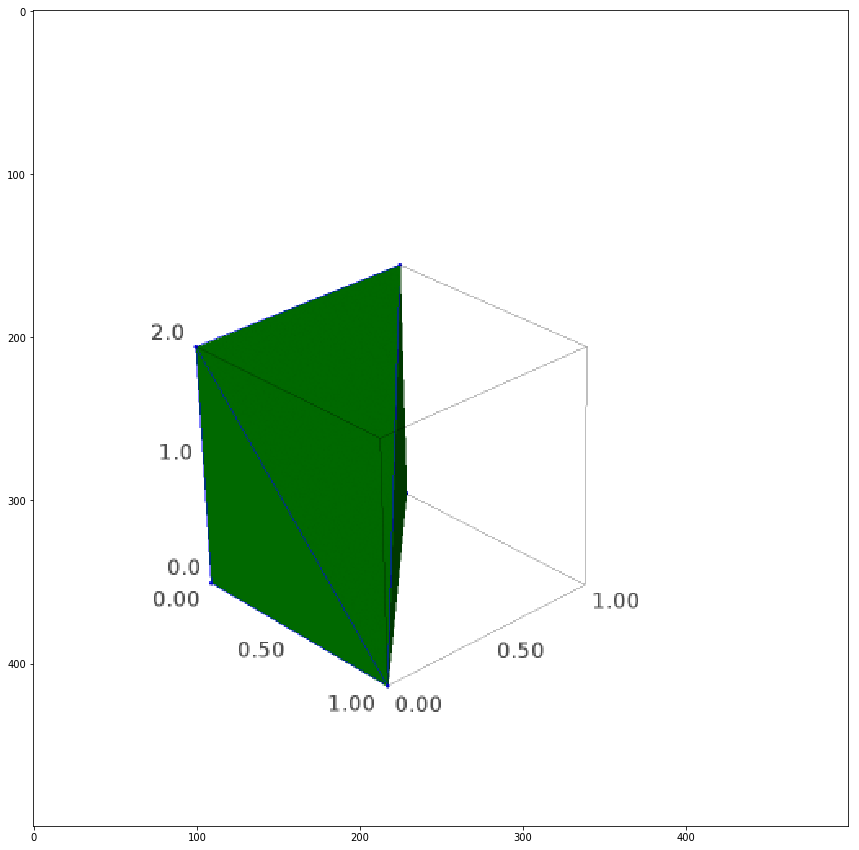

prism:  [[[1, 0, 0], [0, 0, 0], [0, 1, 0], [0, 1, 1]], [[1, 0, 0], [0, 0, 0], [0, 0, 1], [0, 1, 1]], [[1, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 2]], [[1, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2]]]
series:  1/((b1 + b2 - 4)*(b1 - b2 + b3 - 4)*(b1 + b3 - 4)*b1) - 1/((2*b1 + b3 - 8)*(b1 - b2 + b3 - 4)*b1*b2) + 1/((b1 + b3 - 4)*b1*(b2 - b3)*b2) - 1/((b1 + b2 - 4)*b1*(b2 - b3)*b3)
reset starting point:  3.99692297591 3.20322608107 0.772629294012
solution:  [  2.21629357e+38   4.99918741e+39   1.36419089e+39]
volume:  -3.1077836893812785e-158  is out of bounds.
reset starting point:  4.77358453701 4.43654077413 4.14511981744
solution:  [  1.30896359e+37   9.67378099e+37   9.88178449e+37]
volume:  -1.5240088456887022e-152  is out of bounds.
reset starting point:  1.13509548942 2.33131036492 4.09509088593
solution:  [ 1.00000597  1.49999701  2.99998289]
Done.
vol:  0.29629629630653653


/home/carnd/Downloads/SageMath/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


In [17]:
# Triangulate Triangular Prism
def init_prism(h):
    if h == 0:
        prism = []
        series = 0
        return prism, series
    prism_1 = [[[0,0,0],[1,0,0],[0,1,0],[1,0,1]]]
    prism_2 = [[[0,0,0],[1,0,1],[0,1,1],[0,1,0]]]
    prism_3 = [[[0,0,0],[1,0,1],[0,0,1],[0,1,1]]]
    prism = prism_1 + prism_2 + prism_3
    if h == 1:
        series = Hilb(prism)
        return prism, series
    prism_stack = prism
    for z in range(1, h):
        move = np.array([0,0,z])
        for i in range(3):
            # For i-th tetrahedron
            tetra_moved = []
            for j in range(4):
                # For j-th vertex:
                vert_moved = (np.array(prism[i][j])+move).tolist()
                tetra_moved.append(vert_moved)
            prism_stack.append(tetra_moved)
    # Also initialize the Hilbert series
    series = Hilb(prism_stack)
    return prism_stack, series

def Triang_prism(h1, h2, h3):
    # Phase 1: Cube blocks up to min(h1, h2, h3)
    h_list = [h1, h2, h3]
    h_min = min(h_list)
    h_list.remove(h_min)
    prism, series = init_prism(h_min)
    # Phase 2: Tetra with min pt as its apex
    h_min_2 = min(h_list)
    print 'h min: ', h_min
    print 'h min 2: ', h_min_2
    for i in range(h_min_2 - h_min):
        # Also find the Hilbert series for each tetrahedron
        prism_1 = [[[1,0,h_min],[0,0,h_min+i],[0,1,h_min+i],[0,1,h_min+i+1]]]
        series_1 = Hilb(prism_1)
        prism_2 = [[[1,0,h_min],[0,0,h_min+i],[0,0,h_min+i+1],[0,1,h_min+i+1]]]
        series_2 = Hilb(prism_2)
        prism += prism_1 + prism_2
        series += series_1 + series_2
    
    # Phase 3: Tetra with max pt as its apex
    h_max = max(h_list)
    for i in range(h_max-h_min_2):
        prism_new = [[[1,0,h_min],[0,0,h_min_2+i],[0,0,h_min_2+i+1],[0,1,h_min_2]]]
        series_new = Hilb(prism_new)
        prism += prism_new
        series += series_new
    # Plot
    
    plot = []
    for tetra in prism:
        for pts in tetra:
            plot.append(pts)
    #print 'plot: ', plot
    plot_poly(plot)
    
    return prism, series

prism, series = Triang_prism(0,2,2)
print 'prism: ', prism
print 'series: ', series
SIDE_LENGTH = 10
vol, sol = NSolve(series)
print 'vol: ', vol

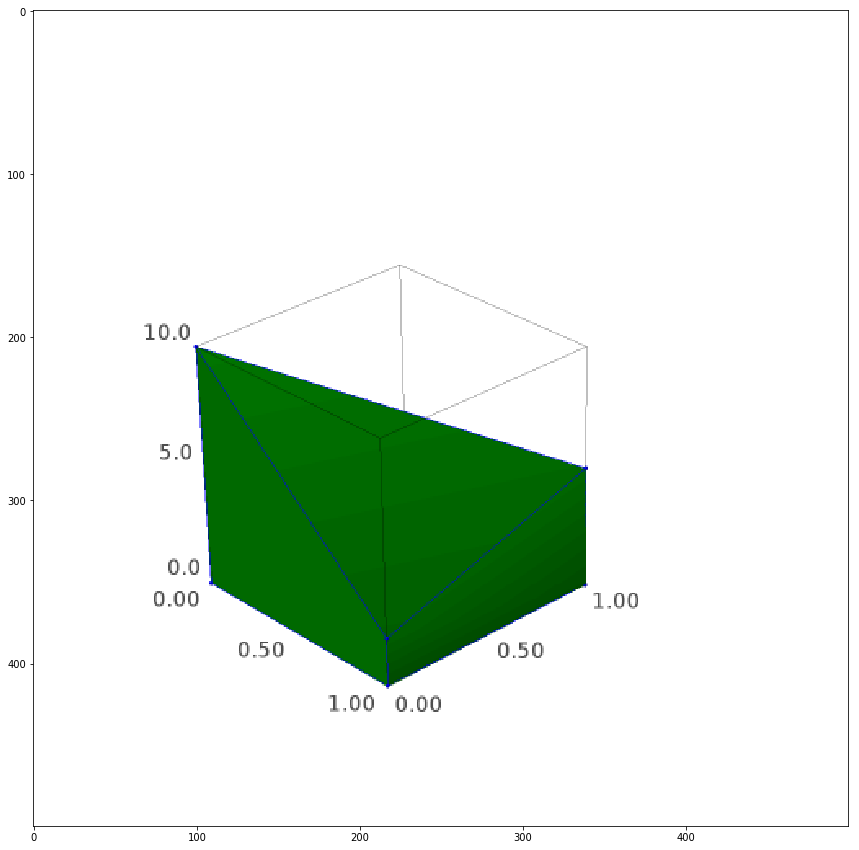

{{0, 0, 0}, {1, 0, 0}, {1, 1, 0}, {0, 0, 1}, {0, 0, 1}, {1, 0, 1}, {1, 0, 0}, {1, 1, 1}, {0, 0, 1}, {1, 1, 1}, {1, 1, 0}, {1, 0, 0}, {0, 0, 0}, {1, 1, 0}, {0, 1, 0}, {0, 0, 1}, {0, 0, 1}, {0, 1, 1}, {1, 1, 0}, {1, 1, 1}, {0, 0, 1}, {0, 1, 1}, {0, 1, 0}, {1, 1, 0}, {1, 0, 1}, {1, 1, 1}, {1, 1, 2}, {0, 0, 2}, {1, 0, 1}, {1, 1, 1}, {0, 0, 1}, {0, 0, 2}, {0, 0, 1}, {1, 1, 1}, {0, 1, 1}, {0, 0, 2}, {0, 0, 2}, {1, 1, 1}, {0, 1, 1}, {1, 1, 2}, {0, 0, 2}, {1, 1, 2}, {1, 0, 1}, {0, 1, 1}, {1, 0, 2}, {0, 0, 2}, {1, 1, 2}, {0, 0, 3}, {1, 0, 2}, {1, 1, 2}, {1, 1, 3}, {0, 0, 3}, {0, 0, 2}, {1, 1, 2}, {0, 1, 1}, {0, 0, 3}, {1, 1, 3}, {1, 1, 2}, {0, 1, 1}, {0, 0, 3}, {1, 0, 2}, {0, 0, 3}, {1, 1, 3}, {0, 0, 4}, {1, 0, 2}, {1, 1, 3}, {1, 1, 4}, {0, 0, 4}, {0, 0, 3}, {1, 1, 3}, {0, 1, 1}, {0, 0, 4}, {1, 1, 4}, {1, 1, 3}, {0, 1, 1}, {0, 0, 4}, {1, 0, 2}, {0, 0, 4}, {1, 1, 4}, {0, 0, 5}, {1, 0, 2}, {1, 1, 4}, {1, 1, 5}, {0, 0, 5}, {0, 0, 4}, {1, 1, 4}, {0, 1, 1}, {0, 0, 5}, {1, 1, 5}, {1, 1, 4}, {0, 1, 1}

In [78]:
# Triangulate the square prism
def init_square_stack(h):
    if h == 0:
        prism = []
        series = 0
        return prism, series
    # Initalize the cube
    cube_1 = [[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]]
    # Sample triangulation of a 1x1x1 cube:
    triang_cube_1_1 = [[[0,0,0],[1,0,0],[1,1,0],[0,0,1]]]
    triang_cube_1_2 = [[[0,0,1],[1,0,1],[1,0,0],[1,1,1]]]
    triang_cube_1_3 = [[[0,0,1],[1,1,1],[1,1,0],[1,0,0]]]
    triang_cube_1_4 = [[[0,0,0],[1,1,0],[0,1,0],[0,0,1]]]
    triang_cube_1_5 = [[[0,0,1],[0,1,1],[1,1,0],[1,1,1]]]
    triang_cube_1_6 = [[[0,0,1],[0,1,1],[0,1,0],[1,1,0]]]
    triang_cube_1 = triang_cube_1_1 + triang_cube_1_2 + triang_cube_1_3 + triang_cube_1_4 + triang_cube_1_5 + triang_cube_1_6
    # Stack the cubes together
    triang = triang_cube_1
    if h == 1:
        series = Hilb(triang)
        return triang, series
    for z in range(1, h):
        move = np.array([0,0,z])
        for i in range(6):
            # The i-th tetrahedron
            tetra_moved = []
            for j in range(4):
                # The j-th vertex
                vert_moved = (np.array(triang_cube_1[i][j])+move).tolist()
                tetra_moved.append(vert_moved)
            triang.append(tetra_moved)
    
    hilb = Hilb(triang)
    
    return triang, hilb

def Triang_square(h1,h2,h3,h4, orient):
    
    # Input: ordered heights (1,0,h1), (0,0,h2), (0,1,h2), (1,1,h4)
    # Find the Orientations:
    # Two orientations (trans:0 or cis:1)
    h_list = [h1, h2, h3, h4]
    h_min = min(h_list)
    h_list.remove(h_min)
    h_min_2 = min(h_list)
    h_list.remove(h_min_2)
    h_min_3 = min(h_list)
    h_list.remove(h_min_3)
    h_max = h_list[0]
    assert h_max >= h_min_3 >= h_min_2 >= h_min
    '''
    h_list = [h1, h2, h3, h4]
    max_idx = h_list.index(h_max)
    min_idx = h_list.index(h_min)
    if (max_idx-min_idx)%2 == 0:
        # Trans: opposite sides
        orient = 0
    elif (max_idx-min_idx)%2 == 1:
        # Cis: the same side
        orient = 1
    print 'Orientation: ', orient
    '''
    # Phase 1: Cube blocks up to h_min
    cube, hilb = init_square_stack(h_min)
    # Phase 2: Tetra transition to triangle base
    if orient == 0:
        # 1243
        for i in range(h_min_2 - h_min):
            prism_1 = [[[1,0,h_min+i],[1,1,h_min],[0,1,h_min+i],[1,0,h_min+i+1]]]
            prism_2 = [[[1,0,h_min+i+1],[1,1,h_min],[0,1,h_min+i],[0,1,h_min+i+1]]]
            prism_3 = [[[0,0,h_min+i],[1,0,h_min+i],[0,1,h_min+i],[0,0,h_min+i+1]]]
            prism_4 = [[[1,0,h_min+i],[1,0,h_min+i+1],[0,0,h_min+i+1],[0,1,h_min+i]]]
            prism_5 = [[[1,0,h_min+i+1],[0,1,h_min+i],[0,1,h_min+i+1],[0,0,h_min+i+1]]]
            prism = prism_1+prism_2+prism_3+prism_4+prism_5
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            series_5 = Hilb(prism_5)
            hilb += series_1 + series_2 + series_3 + series_4 + series_5
        
        for i in range(h_min_3 - h_min_2):
            prism_1 = [[[1,0,h_min_2],[1,1,h_min],[0,0,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_2 = [[[0,0,h_min_2+i],[1,1,h_min],[0,1,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_3 = [[[0,0,h_min_2+i+1],[0,1,h_min_2+i+1],[0,1,h_min_2+i],[1,1,h_min]]]
            prism = prism_1+prism_2+prism_3
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            hilb += series_1 + series_2 + series_3
        
        for i in range(h_max - h_min_3):
            prism_1 = [[[1,0,h_min_2], [1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism_2 = [[[0,1,h_min_3],[1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism = prism_1+prism_2
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            hilb += series_1 + series_2
        
    if orient == 1:
        # 1234
        for i in range(h_min_2 - h_min):
            prism_1 = [[[1,0,h_min],[1,1,h_min+i],[1,1,h_min+i+1],[0,0,h_min+i+1]]]
            prism_2 = [[[1,0,h_min],[1,1,h_min+i],[0,0,h_min+i],[0,0,h_min+i+1]]]
            prism_3 = [[[0,0,h_min+i],[1,1,h_min+i],[0,1,h_min+i],[0,0,h_min+i+1]]]
            prism_4 = [[[0,0,h_min+i+1],[1,1,h_min+i],[0,1,h_min+i],[1,1,h_min+i+1]]]
            prism_5 = [[[0,0,h_min+i+1],[1,1,h_min+i+1],[0,1,h_min+i],[0,1,h_min+i+1]]]
            prism = prism_1+prism_2+prism_3+prism_4+prism_5
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            series_5 = Hilb(prism_5)
            hilb += series_1 + series_2 + series_3 + series_4 + series_5
        
        for i in range(h_min_3 - h_min_2):
            prism_1 = [[[1,0,h_min],[1,1,h_min],[0,0,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_2 = [[[0,0,h_min_2+i],[1,1,h_min],[0,1,h_min_2+i],[0,0,h_min_2+i+1]]]
            prism_3 = [[[0,0,h_min_2+i+1],[0,1,h_min_2+i+1],[0,1,h_min_2+i],[1,1,h_min]]]
            prism = prism_1+prism_2+prism_3
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            hilb += series_1 + series_2 + series_3
        
        for i in range(h_max - h_min_3):
            prism_1 = [[[1,0,h_min], [1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism_2 = [[[0,1,h_min_3],[1,1,h_min],[0,0,h_min_3+i],[0,0,h_min_3+i+1]]]
            prism = prism_1+prism_2
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            hilb += series_1 + series_2
    if orient == 2:
        # 1423
        for i in range(h_min_2 - h_min):
            prism_1 = [[[1,0,h_min+i],[1,1,h_min+i],[1,1,h_min+i+1],[0,0,h_min+i+1]]]
            prism_2 = [[[1,0,h_min+i],[1,1,h_min+i],[0,0,h_min+i],[0,0,h_min+i+1]]]
            prism_5 = [[[0,0,h_min+i+1],[1,1,h_min+i+1],[1,0,h_min+i],[0,1,h_min]]]
            prism_3 = [[[0,0,h_min+i],[1,1,h_min+i],[0,1,h_min],[0,0,h_min+i+1]]]
            prism_4 = [[[0,0,h_min+i+1],[1,1,h_min+i],[0,1,h_min],[1,1,h_min+i+1]]]
            
            prism = prism_1+prism_2+prism_3+prism_4+prism_5
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            series_5 = Hilb(prism_5)
            hilb += series_1 + series_2 + series_3 + series_4 + series_5
        
        
        for i in range(h_min_3 - h_min_2):
            
            prism_1 = [[[1,0,h_min_2],[0,0,h_min_2+i],[1,1,h_min_2+i],[0,0,1+h_min_2+i]]]
            prism_2 = [[[1,0,h_min_2],[1,1,h_min_2+i],[1,1,1+h_min_2+i],[0,0,1+h_min_2+i]]]
            prism_3 = [[[0,0,h_min_2+i],[1,1,h_min_2+i],[0,1,h_min],[0,0,1+h_min_2+i]]]
            prism_4 = [[[1,1,1+h_min_2+i],[1,1,h_min_2+i],[0,1,h_min],[0,0,1+h_min_2+i]]]
            prism = prism_1+prism_2+prism_3+prism_4
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            series_3 = Hilb(prism_3)
            series_4 = Hilb(prism_4)
            hilb += series_1 + series_2 + series_3 + series_4
        
        
        for i in range(h_max - h_min_3):
            prism_1 = [[[1,0,h_min_2],[1,1,h_min_3],[0,0,h_min_3+i],[0,0,1+h_min_3+i]]]
            prism_2 = [[[0,1,h_min],[1,1,h_min_3],[0,0,h_min_3+i],[0,0,1+h_min_3+i]]]
            prism = prism_1+prism_2
            cube += prism
            
            series_1 = Hilb(prism_1)
            series_2 = Hilb(prism_2)
            hilb += series_1 + series_2
            
    return cube, hilb

cube, hilb = Triang_square(1,2,10,5, 2)

plot = []
for tetra in cube:
    for vert in tetra:
        plot.append(vert)
plot_poly(plot)

plot_str = str(plot).replace('[', '{').replace(']','}')
print plot_str


In [46]:
pts = [[1, 0, 1], [1, 1, 1], [0, 1, 1], [1, 0, 2], [1, 0, 2], [1, 1, 1], [0, 1, 1], [0, 1, 2], [0, 0, 1], [1, 0, 1], [0, 1, 1], [0, 0, 2], [1, 0, 1], [1, 0, 2], [0, 0, 2], [0, 1, 1], [1, 0, 2], [0, 1, 1], [0, 1, 2], [0, 0, 2], [1, 0, 2], [1, 1, 1], [0, 1, 2], [1, 0, 3], [1, 0, 3], [1, 1, 1], [0, 1, 2], [0, 1, 3], [0, 0, 2], [1, 0, 2], [0, 1, 2], [0, 0, 3], [1, 0, 2], [1, 0, 3], [0, 0, 3], [0, 1, 2], [1, 0, 3], [0, 1, 2], [0, 1, 3], [0, 0, 3], [1, 0, 3], [1, 1, 1], [0, 1, 3], [1, 0, 4], [1, 0, 4], [1, 1, 1], [0, 1, 3], [0, 1, 4], [0, 0, 3], [1, 0, 3], [0, 1, 3], [0, 0, 4], [1, 0, 3], [1, 0, 4], [0, 0, 4], [0, 1, 3], [1, 0, 4], [0, 1, 3], [0, 1, 4], [0, 0, 4], [1, 0, 4], [1, 1, 1], [0, 1, 4], [1, 0, 5], [1, 0, 5], [1, 1, 1], [0, 1, 4], [0, 1, 5], [0, 0, 4], [1, 0, 4], [0, 1, 4], [0, 0, 5], [1, 0, 4], [1, 0, 5], [0, 0, 5], [0, 1, 4], [1, 0, 5], [0, 1, 4], [0, 1, 5], [0, 0, 5], [1, 0, 5], [1, 1, 1], [0, 1, 5], [1, 0, 6], [1, 0, 6], [1, 1, 1], [0, 1, 5], [0, 1, 6], [0, 0, 5], [1, 0, 5], [0, 1, 5], [0, 0, 6], [1, 0, 5], [1, 0, 6], [0, 0, 6], [0, 1, 5], [1, 0, 6], [0, 1, 5], [0, 1, 6], [0, 0, 6]]
pts = str(pts).replace('[', '{').replace(']','}')
print pts

{{1, 0, 1}, {1, 1, 1}, {0, 1, 1}, {1, 0, 2}, {1, 0, 2}, {1, 1, 1}, {0, 1, 1}, {0, 1, 2}, {0, 0, 1}, {1, 0, 1}, {0, 1, 1}, {0, 0, 2}, {1, 0, 1}, {1, 0, 2}, {0, 0, 2}, {0, 1, 1}, {1, 0, 2}, {0, 1, 1}, {0, 1, 2}, {0, 0, 2}, {1, 0, 2}, {1, 1, 1}, {0, 1, 2}, {1, 0, 3}, {1, 0, 3}, {1, 1, 1}, {0, 1, 2}, {0, 1, 3}, {0, 0, 2}, {1, 0, 2}, {0, 1, 2}, {0, 0, 3}, {1, 0, 2}, {1, 0, 3}, {0, 0, 3}, {0, 1, 2}, {1, 0, 3}, {0, 1, 2}, {0, 1, 3}, {0, 0, 3}, {1, 0, 3}, {1, 1, 1}, {0, 1, 3}, {1, 0, 4}, {1, 0, 4}, {1, 1, 1}, {0, 1, 3}, {0, 1, 4}, {0, 0, 3}, {1, 0, 3}, {0, 1, 3}, {0, 0, 4}, {1, 0, 3}, {1, 0, 4}, {0, 0, 4}, {0, 1, 3}, {1, 0, 4}, {0, 1, 3}, {0, 1, 4}, {0, 0, 4}, {1, 0, 4}, {1, 1, 1}, {0, 1, 4}, {1, 0, 5}, {1, 0, 5}, {1, 1, 1}, {0, 1, 4}, {0, 1, 5}, {0, 0, 4}, {1, 0, 4}, {0, 1, 4}, {0, 0, 5}, {1, 0, 4}, {1, 0, 5}, {0, 0, 5}, {0, 1, 4}, {1, 0, 5}, {0, 1, 4}, {0, 1, 5}, {0, 0, 5}, {1, 0, 5}, {1, 1, 1}, {0, 1, 5}, {1, 0, 6}, {1, 0, 6}, {1, 1, 1}, {0, 1, 5}, {0, 1, 6}, {0, 0, 5}, {1, 0, 5}, {0, 1, 5}

In [47]:
h_min = 1
h_min_2 = 3
cube = []
plot = []
for i in range(h_min_2 - h_min):
    prism_1 = [[[1,0,h_min+i],[1,1,h_min],[0,1,h_min+i],[1,0,h_min+i+1]]]
    prism_2 = [[[1,0,h_min+i+1],[1,1,h_min],[0,1,h_min+i],[0,1,h_min+i+1]]]
    prism_3 = [[[0,0,h_min+i],[1,0,h_min+i],[0,1,h_min+i],[0,0,h_min+i+1]]]
    prism_4 = [[[1,0,h_min+i],[1,0,h_min+i+1],[0,0,h_min+i+1],[0,1,h_min+i]]]
    prism_5 = [[[1,0,h_min+i+1],[0,1,h_min+i],[0,1,h_min+i+1],[0,0,h_min+i+1]]]
    prism = prism_1+prism_2+prism_3+prism_4+prism_5
    cube += prism

    for tetra in prism:
        for vert in tetra:
            plot.append(vert)

print cube

[[[1, 0, 1], [1, 1, 1], [0, 1, 1], [1, 0, 2]], [[1, 0, 2], [1, 1, 1], [0, 1, 1], [0, 1, 2]], [[0, 0, 1], [1, 0, 1], [0, 1, 1], [0, 0, 2]], [[1, 0, 1], [1, 0, 2], [0, 0, 2], [0, 1, 1]], [[1, 0, 2], [0, 1, 1], [0, 1, 2], [0, 0, 2]], [[1, 0, 2], [1, 1, 1], [0, 1, 2], [1, 0, 3]], [[1, 0, 3], [1, 1, 1], [0, 1, 2], [0, 1, 3]], [[0, 0, 2], [1, 0, 2], [0, 1, 2], [0, 0, 3]], [[1, 0, 2], [1, 0, 3], [0, 0, 3], [0, 1, 2]], [[1, 0, 3], [0, 1, 2], [0, 1, 3], [0, 0, 3]]]


In [ ]:
import math
import numpy as np
import scipy
import scipy.optimize
import csv
from scipy.optimize import fsolve

PointConfiguration.set_engine('internal')
#PointConfiguration.set_engine('topcom')

def exist(pts, latt):
    latt = np.array(latt)
    for i in range(pts.shape[0]):
        if pts[i][0]==latt[0]:
            if pts[i][1]==latt[1]:
                if pts[i][2]==latt[2]:
                    return 1
    return 0

def contain(poly, latt):
    if poly.contains(latt) == 1:
        return 1
    else:
        poly_latt = Polyhedron(vertices = [tuple(latt)])
        vert = next(poly_latt.vertex_generator())
        face_eq = poly.Hrepresentation()
        for eq in face_eq:
            if eq.contains(vert) != 1:
                return 0
        return 1
    return 0

def check_latt(p):
    pts = np.array(p)
    pts_max = int(max(np.amax(pts, axis=0)))+1
    pts_min = int(min(np.amin(pts, axis=0)))-1
    poly = Polyhedron(p)
    pts_new = pts
    for i in range(pts_min, pts_max):
        for j in range(pts_min, pts_max):
            for k in range(pts_min, pts_max):
                latt = [i,j,k]
                if exist(pts, latt) == 1:
                    continue
                if contain(poly, latt) == 1:
                    pts_new = np.append(pts_new, np.array(latt).reshape((1,3)), axis = 0)  
    pts_new = pts_new.tolist()
    return pts_new

def dist(p1, p2):
    return sqrt((p1[0]-p2[0])^2+(p1[1]-p2[1])^2+(p1[2]-p2[2])^2)

def on_edge(latt, poly):
    edges = poly.faces(1)
    num_edges = len(edges)
    for i in range(num_edges):
        pt1 = list(edges[i].vertices()[0])
        pt2 = list(edges[i].vertices()[1])
        if (dist(pt1, pt2) == (dist(pt1, latt) + dist(pt2, latt))):
            return 1
    return 0

def on_face(latt, poly):
    faces = poly.faces(2)
    for face in poly.faces(2):
        face_pts = [list(face.vertices()[i]) for i in range(len(face.vertices()))]
        face_poly = Polyhedron(face_pts)
        if face_poly.contains(latt) == 1:
            return 1
    return 0

def count_pts(pts):
    # Count the number of corner points, edge points, face points, and body points
    num_corner = len(pts)
    num_edge = 0
    num_face = 0
    num_body = 0
    #edge = []
    #face = []
    #body = []
    pts_max = int(max(np.amax(pts, axis=0)))+1
    pts_min = int(min(np.amin(pts, axis=0)))-1
    poly = Polyhedron(pts)
    pts_new = pts
    for i in range(pts_min, pts_max):
        for j in range(pts_min, pts_max):
            for k in range(pts_min, pts_max):
                latt = [i,j,k]
                if exist(np.array(pts), latt) == 1:
                    continue
                if on_edge(latt, poly) == 1:
                    num_edge += 1
                    #edge.append(latt)
                elif on_face(latt, poly) == 1:
                    num_face += 1
                    #face.append(latt)
                elif poly.interior_contains(latt) == 1:
                    num_body += 1
                    #body.append(latt)
    #print 'edge: ', edge
    #print 'face: ', face
    #print 'body: ', body
    return [num_corner, num_edge, num_face, num_body]

def four_cross(v1, v2, v3, v4):
    #Compute cross product of three 4-vectors
    #print "input vectors: ", v1, v2, v3, v4
    v = np.zeros((4,))
    counter = 0
    
    for i in range(4):
        mat = [v1[np.arange(len(v1))!=i].tolist(), v2[np.arange(len(v2))!=i].tolist(), v3[np.arange(len(v3))!=i].tolist()]
        mat = matrix(ZZ, mat)
        #print 'matrix: '
        #print mat
        if counter == 1:
            v[i] = -1*mat.det()
            counter = 0
            #print 'neg: ', v[i]
            continue
        elif counter == 0:
            v[i] = mat.det()
            counter = 1
            #print 'pos: ', v[i]
    #print v
    mat = matrix(RR, [v1.tolist(), v2.tolist(), v3.tolist(), v4.tolist()])
    
    if mat.det() < 0:
        #print 'original: ', v
        v = -1*v
        #print 'changed: ', v
    #print 'vector: ', v
    return v

def Hilb(triang_list):
    triang = []
    # Add 1 at the end of all verticies
    for tetra in triang_list:
        tetra_new = []
        for vert in tetra:
            vert_new = np.append(np.array(vert),1).tolist()
            tetra_new.append(vert_new)
        triang.append(tetra_new)
    triang = np.array(triang)
    #print 'input: ', triang_list
    #print 'triang: ', triang
    power = np.zeros(shape = triang.shape)
    Hilb = 0
    t = var('t')
    t1 = var('t1')
    t2 = var('t2')
    t3 = var('t3')
    t4 = var('t4')
    for tri in range(triang.shape[0]):
        hilb = 1
        t_prod = 1
        for i in range(4):
            #Multiplying by -1 is optional
            try:
                power[tri][i] = -1*four_cross(triang[tri][i], triang[tri][np.remainder(i+1, 4)], triang[tri][np.remainder(i+2, 4)], triang[tri][np.remainder(i+3, 4)])
                t_prod = t1^(int(power[tri][i][0]))*t2^(int(power[tri][i][1]))*t3^(int(power[tri][i][2]))*t4^int((power[tri][i][3]))
                hilb *= (1-t_prod)^(-1)
            except:
                print 'tri: ', tri
                print 'i', i
                print 'triang shape: ', triang.shape
                print 'values: ', triang[tri][i], triang[tri][np.remainder(i+1, 4)], triang[tri][np.remainder(i+2, 4)], triang[tri][np.remainder(i+3, 4)]
                print 't_prod: ', t_prod
                raise ValueError('Triang too short.')
        #print 'Hilbert: ', hilb
        Hilb += hilb
    
    
    m = var('m')
    b1 = var('b1')
    b2 = var('b2')
    b3 = var('b3')
    b4 = var('b4')
    Hilb *= m^4
    
    #print 'Hilb: ', str(Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp())).replace('e', 'E')
    
    
    Series = Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp()).series(m==0, 1)
    Series = Series.truncate()
    
    return Series



def func(p, *d):
    f1, f2, f3 = d
    return (f1(b1 = p[0], b2 = p[1], b3 = p[2]), f2(b1 = p[0], b2 = p[1], b3 = p[2]), f3(b1 = p[0], b2 = p[1], b3 = p[2]))

def constraint(Series, sol):
    vol = Series(b1 = sol[0], b2 = sol[1], b3 = sol[2])
    if vol <= 1 and vol >= float(1/((3*SIDE_LENGTH)**3)):
        return 1, vol

    print 'volume: ', vol, ' is out of bounds.'

    return 0, -1

def NSolve(Series):
    d1 = diff(Series, b1)
    d2 = diff(Series, b2)
    d3 = diff(Series, b3)
    d = (d1, d2, d3)
    const = 0
    count = 0

    while const == 0:
        d1_0 = np.random.uniform(low=0, high=5)
        d2_0 = np.random.uniform(low=0, high=5)
        d3_0 = np.random.uniform(low=0, high=5)
        print 'reset starting point: ', d1_0, d2_0, d3_0

        try:
            sol = fsolve(func, x0 = np.array([d1_0, d2_0, d3_0]), args = d)
            print 'solution: ', sol
        except:
            continue
        
        const, vol = constraint(Series, sol)

        count += 1
        if count > 1000:
            print 'Infinite loop. Force stop.'
            return -1, -1

    print 'Done.'

    return vol, sol


def idx_to_pts(triang, pts):
    # Input a list of lists of indicies
    # Output a list of lists of points
    triang_new = []
    for i in range(len(triang)):
        triang_new.append([pts[j] for j in triang[i]])
    return triang_new

def init_cube(size):
    if size == 0:
        corner = []
        triang = []
        hilb = 0
        return corner, triang, hilb
    # Initalize the cube
    cube_1 = [[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]]
    corner = (size*np.array(cube_1)).tolist()
    # Sample triangulation of a 1x1x1 cube:
    triang_cube_1_1 = [[[0,0,0],[1,0,0],[1,1,0],[0,0,1]]]
    triang_cube_1_2 = [[[0,0,1],[1,0,1],[1,0,0],[1,1,1]]]
    triang_cube_1_3 = [[[0,0,1],[1,1,1],[1,1,0],[1,0,0]]]
    triang_cube_1_4 = [[[0,0,0],[1,1,0],[0,1,0],[0,0,1]]]
    triang_cube_1_5 = [[[0,0,1],[0,1,1],[1,1,0],[1,1,1]]]
    triang_cube_1_6 = [[[0,0,1],[0,1,1],[0,1,0],[1,1,0]]]
    triang_cube_1 = triang_cube_1_1 + triang_cube_1_2 + triang_cube_1_3 + triang_cube_1_4 + triang_cube_1_5 + triang_cube_1_6
    # Stack the cubes together
    triang = triang_cube_1
    if size == 1:
        hilb = []
        for tetra in triang:
            series = Hilb([tetra])
            hilb.append(series)
        return corner, triang, hilb
    for x in range(0,size):
        for y in range(0,size):
            for z in range(0,size):
                if x==0 and y==0 and z ==0:
                    continue
                move = [x, y, z]
                move = np.array(move)
                for i in range(6):
                    # The i-th tetrahedron
                    tetra_moved = []
                    for j in range(4):
                        # The j-th vertex
                        vert_moved = (np.array(triang_cube_1[i][j])+move).tolist()
                        tetra_moved.append(vert_moved)
                    triang.append(tetra_moved)
    # Also initialize the Hilbert series for each tetrahedron
    hilb = []
    for tetra in triang:
        series = Hilb([tetra])
        hilb.append(series)
    #print 'Init cube'
    #print 'Hilbert series: ', hilb
    return corner, triang, hilb

def cut_corner(p, corner, triang, hilb):
    corner = check_latt(corner)
    corner.remove(p)
    cube_new = Polyhedron(corner)
    vertices = cube_new.vertices()
    corner = [list(vertices[i]) for i in range(len(vertices))]
    #print 'corner: ', corner
    # Find all the tetrahedron points that contain p
    adj_pts = []
    triang_new = []
   
    for tetra in triang:
        if p in tetra:
            # Hilbert
            for vertex in tetra:
                if (vertex != p) and (vertex not in adj_pts):
                    adj_pts.append(vertex)
            
            # I do not trust indexing
            series = Hilb([tetra])
            #print 'remove hilb: ', series
            hilb.remove(series)
        else:
            triang_new.append(tetra)
    if len(hilb) != len(triang_new):
        print 'len(hilb): ', len(hilb)
        print 'len(triang_new): ', len(triang_new)
    triang = triang_new
    #print 'adjacent points: ', adj_pts
    if len(adj_pts) > 3:
        patch = Polyhedron(adj_pts)
        patch_triang = PointConfiguration(adj_pts).triangulate()
        patch_triang = idx_to_pts(patch_triang, adj_pts)
        print 'patch: ', patch_triang
        for tetra in patch_triang:
            print 'Number of tetrahedron: ', len(tetra)
            if len(tetra) > 3:
                if tetra not in triang:
                    triang.append(tetra)
                    # Also find the Hilbert Series for each tetrahedron
                    series = Hilb([tetra])
                    hilb.append(series)
                if len(hilb) != len(triang_new):
                    print 'len(hilb): ', len(hilb)
                    print 'len(triang_new): ', len(triang_new)
                    print 'tetra: ', tetra
    #print 'number of tetrahedron: ', len(triang)
    return corner, triang, hilb

def plot_poly(pts):
    P = Polyhedron(pts)
    P.plot().save("/home/carnd/CYML/img/triang_cube_%d.png" % 1)
    img1 = mpimg.imread("/home/carnd/CYML/img/triang_cube_%d.png" % 1)
    plt.figure(figsize=(15, 15))
    plt.imshow(img1)
    plt.show()

points_cut = [[2, 2, 0], [0, 2, 0], [2, 1, 0], [0, 2, 1], [2, 0, 0], [0, 0, 0], [0, 1, 0], [2, 0, 1], [0, 0, 2], [0, 2, 2], [2, 1, 1], [0, 0, 1], [1, 0, 0], [1, 1, 0], [2, 2, 1], [0, 1, 1], [0, 1, 2], [1, 2, 0], [1, 2, 1], [2, 2, 2], [1, 0, 1], [2, 0, 2]]
    
def Triang_cube(size):
    corner, triang, hilb = init_cube(size)
    points = []
    # Cut a random corner of the cube
    series_sum = 0
    for series in hilb:
        series_sum += series
    hilb_ret = [series_sum]
    count_ret = [count_pts(corner)]
    print 'Init count_ret: ', count_ret
    pts_ret = [corner]
    stop = 0
    for i in range(len(points_cut)):
        #idx = np.random.randint(len(corner))
        #p = corner[idx]
        p = points_cut[i]
        print 'p: ', p
        points.append(p)
        try:
            corner, triang, hilb = cut_corner(p, corner, triang, hilb)
        except:
            print 'points: ', points
            raise ValueError('Cutting corner failed.')
        
        try:
            assert len(hilb) == len(triang)
        except:
            print 'points: ', points
            print('len(hilb)', len(hilb))
            print('hilb', hilb)
            print('triang', triang)
            raise ValueError('Length not equal.')
        
        pts_ret.append(corner)
        
        count = count_pts(corner)
        count_ret.append(count)
        print 'count: ', count
        
        series_sum = 0
        for series in hilb:
            series_sum += series
        hilb_ret.append(series_sum)
        
        print ''
        if len(corner) <= 4:
            stop = 1
            break
    
    try:
        assert len(pts_ret) == len(count_ret) == len(hilb_ret)
    except:
        print('len(hilb_ret)', len(hilb_ret))
        print('hilb_ret', hilb_ret)
        print('len(count_ret)', len(count_ret))
        print('count_ret', count_ret)
        print('len(pts_ret)', len(pts_ret))
        print('pts_ret', pts_ret)
        raise ValueError('Length not equal.')
        
    return hilb_ret, pts_ret, count_ret

def vol_cube(size, train_path, count_path, pts_path):
    hilb, pts, count = Triang_cube(size)
    #train_file = open(train_path, 'w')
    #count_file = open(count_path, 'w')
    #pts_file = open(pts_path, 'w')
    for i in range(len(hilb)):
        vol, sol = NSolve(hilb[i])
        sol = np.around(sol, decimals=4).tolist()
        print 'vol: ', vol
        print 'sol: ', sol
        train_set = [pts[i], vol]
        print 'train: ', train_set
        count_set = [count[i], vol]
        print 'count: ', count_set
        pts_set = [pts[i], sol]
        print 'pts_set: ', pts_set
        
        #train_file.write("%s\n" % train_set)
        #count_file.write("%s\n" % count_set)
        #pts_file.write("%s\n" % pts_set)
    #train_file.close()
    #count_file.close()
    #pts_file.close()
    
    print 'Done.'

size = 2
#num_iteration = 100
SIDE_LENGTH = size
train_path = '/home/carnd/CYML/output/train/cube/cube_%dx%d.txt' % (size, size)
count_path = '/home/carnd/CYML/output/train/cube/count_%dx%d.txt' % (size, size)
pts_path = '/home/carnd/CYML/output/polygon/cube/pts_%dx%d.txt' % (size, size)
vol_cube(size, train_path, count_path, pts_path)

Init count_ret:  [[8, 12, 6, 1]]
p:  [2, 2, 0]
patch:  [[[1, 1, 0], [2, 1, 0], [1, 1, 1], [1, 2, 1]], [[1, 1, 0], [2, 1, 0], [1, 2, 0], [1, 2, 1]], [[2, 1, 0], [1, 1, 1], [2, 2, 1], [1, 2, 1]], [[2, 1, 0], [2, 2, 1], [1, 2, 0], [1, 2, 1]]]
Number of tetrahedron:  4
Number of tetrahedron:  4
Number of tetrahedron:  4
Number of tetrahedron:  4
count:  [10, 9, 6, 1]

p:  [0, 2, 0]
patch:  [[[0, 1, 0], [1, 2, 0], [0, 1, 1], [0, 2, 1]]]
Number of tetrahedron:  4
count:  [11, 7, 6, 1]

p:  [2, 1, 0]
patch:  [[[1, 0, 0], [2, 0, 0], [1, 0, 1], [1, 2, 0]], [[2, 0, 0], [1, 0, 1], [2, 1, 1], [2, 2, 1]], [[2, 0, 0], [1, 0, 1], [2, 2, 1], [1, 2, 0]], [[1, 0, 1], [1, 1, 1], [2, 2, 1], [1, 2, 0]], [[1, 1, 1], [2, 2, 1], [1, 2, 1], [1, 2, 0]]]
Number of tetrahedron:  4
Number of tetrahedron:  4
Number of tetrahedron:  4
Number of tetrahedron:  4
Number of tetrahedron:  4
count:  [10, 7, 6, 1]

p:  [0, 2, 1]
patch:  [[[0, 1, 1], [1, 2, 1], [0, 1, 2], [0, 2, 2]], [[0, 1, 1], [1, 2, 1], [0, 2, 2], [0, 1,

In [7]:
import numpy as np

triang_list = [[[1, 1, 1], [1, 2, 2], [1, 0, 2]]]
triang = []
# Add 1 at the end of all verticies
for tetra in triang_list:
    tetra_new = []
    for vert in tetra:
        vert_new = np.append(np.array(vert),1).tolist()
        tetra_new.append(vert_new)
    triang.append(tetra_new)
triang = np.array(triang)
for tri in range(triang.shape[0]):
    hilb = 1
    t_prod = 1
    for i in range(4):
        #Multiplying by -1 is optional
        try:
            power[tri][i] = -1*four_cross(triang[tri][i], triang[tri][np.remainder(i+1, 4)], triang[tri][np.remainder(i+2, 4)], triang[tri][np.remainder(i+3, 4)])
            t_prod = t1^(int(power[tri][i][0]))*t2^(int(power[tri][i][1]))*t3^(int(power[tri][i][2]))*t4^int((power[tri][i][3]))
            hilb *= (1-t_prod)^(-1)
        except:
            print 'tri: ', tri
            print 'i:', i
            print 'triang shape: ', triang.shape
            print np.remainder(i+3, 4)
            print triang[tri]
            print triang[tri][np.remainder(i+3, 4)]
            print 't_prod: ', t_prod
            raise ValueError('Triang too short.')

tri:  0
i: 0
triang shape:  (1, 3, 4)
3
[[1 1 1 1]
 [1 2 2 1]
 [1 0 2 1]]


IndexError: index 3 is out of bounds for axis 0 with size 3